In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Display some predictions."""
import os
from pathlib import Path
import numpy as np
from tensorflow.keras.models import load_model
# import matplotlib.pyplot as plt
from nmp import dataset
# from tensorflow.keras.layers import LSTM
import tensorflow as tf
import copy
import pandas as pd
from nmp.dataset import pyplot_piano_roll, write_midi
from nmp import model as mod
import matplotlib.pyplot as plt
import time
import pypianoroll
import random

P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook

PLOTS = P / 'plots'  # Plots path
BS = 64
FS = 24  # Sampling frequency. 10 Hz = 100 ms
Q = 0  # Quantize?
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
DOWN = 12  # Downsampling factor
# D = "data/Nottingham/test"  # Dataset (synth or data)
D = "data/Piano-midi.de/test"  # Dataset (synth or data)
# D = "data/JSB Chorales/test"  # Dataset (synth or data)

# MODEL = 'simpleRNN-nottingham-3.h5'
# MODEL_FF = 'ff-z-nottingham'
model_type = 'rnn'

LOW_LIM = 33  # A1
HIGH_LIM = 97  # C7

NUM_NOTES = HIGH_LIM - LOW_LIM
CROP = [LOW_LIM, HIGH_LIM]  # Crop plots

# TensorFlow stuff
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
# # Load model.
# model = load_model(filepath=str(P / 'models' / MODEL),
#                    custom_objects=None, compile=True)
# model.summary()

In [3]:
checkpoint_dir = P / ('models/take/lstm-jsb')
model = mod.build_gru_model(NUM_NOTES, 1)
mod.compile_model(model, 'binary_crossentropy', 'adam',
                  metrics=['accuracy'])
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 128)            393728    
_________________________________________________________________
dense (Dense)                (1, None, 64)             8256      
_________________________________________________________________
Output (Dense)               (1, None, 640)            41600     
Total params: 443,584
Trainable params: 443,584
Non-trainable params: 0
_________________________________________________________________


In [4]:
checkpoint_dir = P / ('models/take/ff-jsb')
model_ff = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
mod.compile_model(model_ff, 'binary_crossentropy', 'adam',
                  metrics=['accuracy', mod.f1])
model_ff.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_ff.build(tf.TensorShape([1, None]))
model_ff.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                10272     
_________________________________________________________________
Output (Dense)               (None, 640)               21120     
Total params: 33,472
Trainable params: 33,472
Non-trainable params: 0
_________________________________________________________________


In [5]:
# model_ff = load_model(filepath=str(P / 'models' / MODEL_FF),
#                    custom_objects=None, compile=True)
# model.summary()

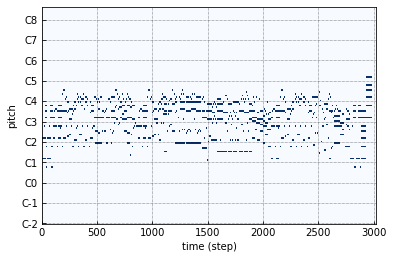

In [6]:
BASE = 0
hm = 4

# FILE = D + '/' + 'ashover_simple_chords_5.mid'
# FILE = 'midi_tests/pattern4BIS.mid'
# FILE = 'midi_tests/bach-minuetto3.mid'
# FILE = D + '/' + 'ashover_simple_chords_5.mid'  # Nottingham
TRACK = 'alb_esp2.mid'
FILE = D + '/' + TRACK
test_file = dataset.import_one(str(FILE), 24)

# FILE = 'jigs_simple_chords_17.mid'
# FILE = 'jigs_simple_chords_101.mid'
# FILE = 'playford_simple_chords_5.mid'
# FILE = 'jigs_simple_chords_227.mid'


test_file = test_file[:, LOW_LIM:HIGH_LIM]
pyplot_piano_roll(test_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM)
STOP = 960

In [7]:
print(test_file.shape)

model.reset_states()
m = 12
random.seed(3)
before = copy.deepcopy(test_file)
ff_file = copy.deepcopy(test_file)
base_file = copy.deepcopy(test_file)
err_pos = range(2, int(test_file.shape[0]/(24*m)))
err_pos = [x*24*m + 12 for x in err_pos]

# err_pos=[288]
# err_pos = [100]
# for error in [60*x for x in range(1, 50)]:
errors = []
size = 10
for error in err_pos:
    occurs = random.choice([1])
    if occurs:
        errors.append(error)
        print("Error at timestep n. %d" % error)
        try:
            ff_file = dataset.fill_gap(ff_file, model_ff, error, size=size, baseline=BASE, how_many=hm)
            test_file = dataset.fill_gap_rnn_final(test_file, model, error, size=size, baseline=BASE, how_many=hm)
            base_file = dataset.fill_gap_hold(base_file, error, size=size)
                
        except Exception as e:
            print(e)
print(test_file.shape)
print(errors)

(3024, 64)
Error at timestep n. 588
Error at timestep n. 876
Error at timestep n. 1164
Error at timestep n. 1452
Error at timestep n. 1740
Error at timestep n. 2028
Error at timestep n. 2316
Error at timestep n. 2604
(3024, 64)
[588, 876, 1164, 1452, 1740, 2028, 2316, 2604]


In [8]:
if errors[-1] > test_file.shape[0]:
    errors.pop()

In [9]:
# plt.rcParams["figure.figsize"] = (3, 3)
# for e in errors:
#     x1 = e
#     x2 = e + size*12
#     xcrop = [e, e + size*12]
#     pyplot_piano_roll(before, low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Greens')
#     plt.ylim([33, 97])
#     plt.xlim(xcrop)
#     plt.title("Real")
#     pyplot_piano_roll(ff_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Reds')
#     plt.ylim([33, 97])
#     plt.xlim(xcrop)
#     plt.title("Feed forward")
#     pyplot_piano_roll(test_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Blues')
#     plt.ylim([33, 97])
#     plt.xlim(xcrop)
#     plt.title("RNN")
#     pyplot_piano_roll(base_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Blues')
#     plt.ylim([33, 97])
#     plt.xlim(xcrop)
#     plt.title("Hold baseline")
#     continue


In [10]:
db = []
db += [e for e in errors]
db += [e+size*12 for e in errors]
db.sort()
print(db)

[588, 708, 876, 996, 1164, 1284, 1452, 1572, 1740, 1860, 2028, 2148, 2316, 2436, 2604, 2724]


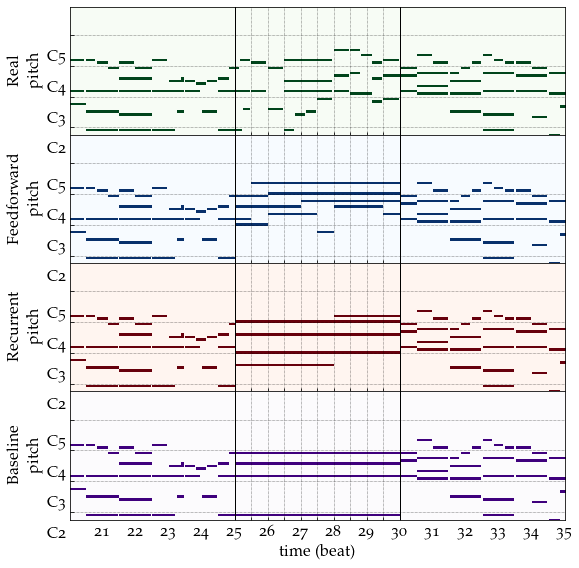

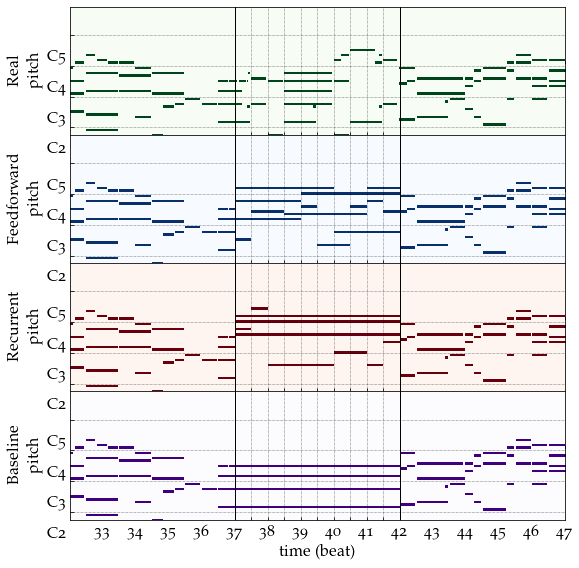

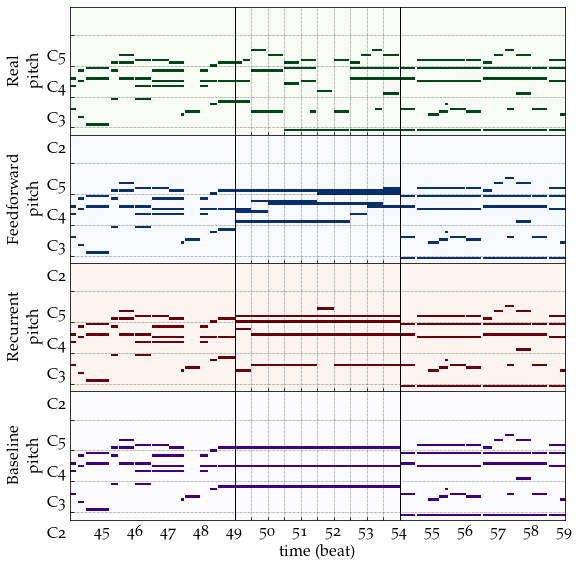

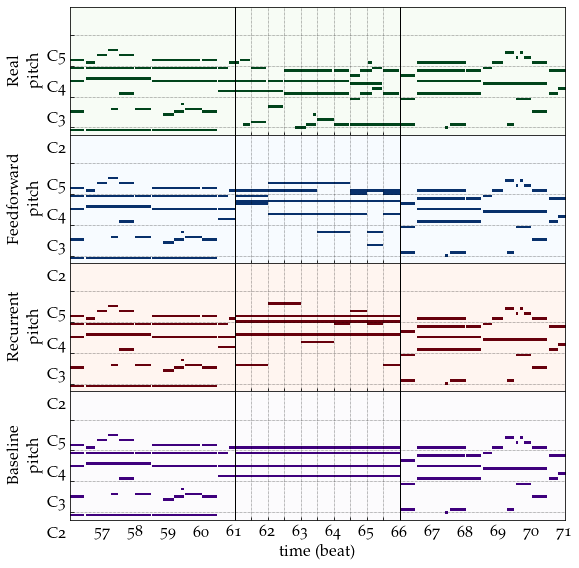

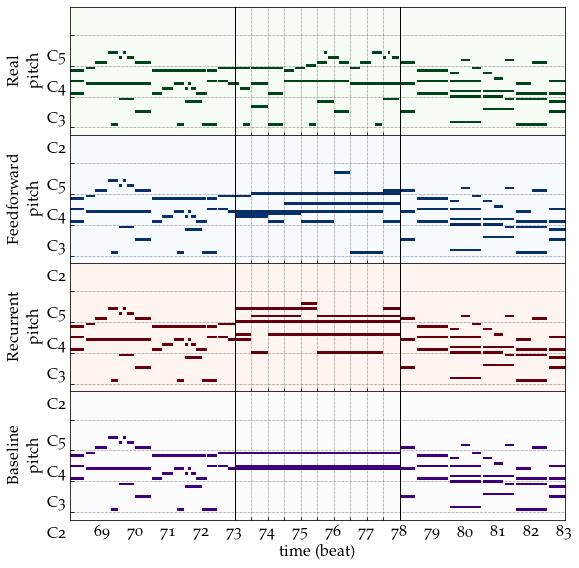

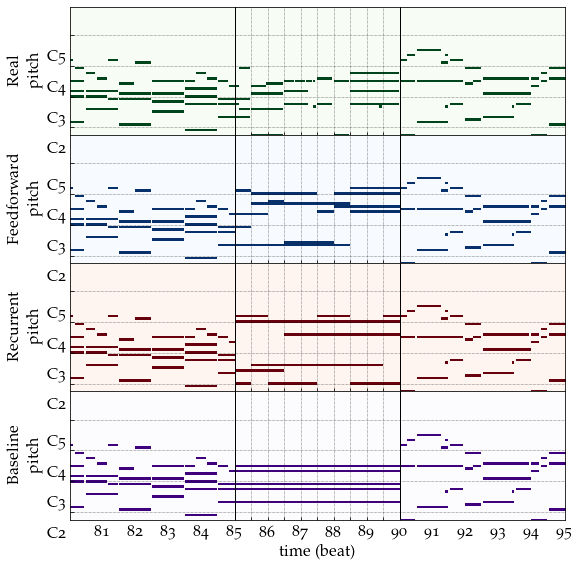

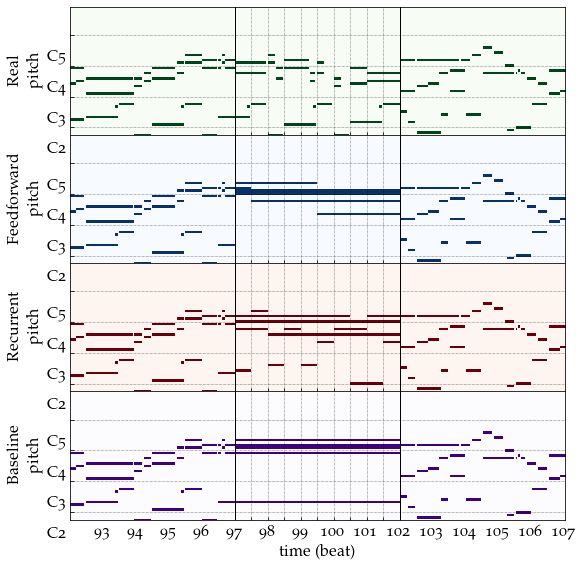

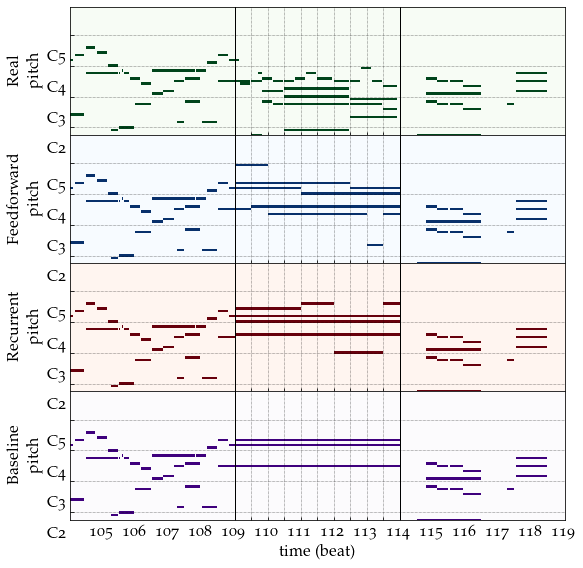

In [11]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.constrained_layout.use"] = True

import matplotlib
from matplotlib import rc
matplotlib.rcParams['mathtext.rm'] = 'custom'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['font.family'] = 'custom'

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{classicthesis}')
plt.rcParams.update({'font.size': 16})

tr1 = pypianoroll.Track(dataset.pad_piano_roll(before, low_lim=LOW_LIM, high_lim=HIGH_LIM), name='Real')
tr2 = pypianoroll.Track(dataset.pad_piano_roll(ff_file, low_lim=LOW_LIM, high_lim=HIGH_LIM), name='Feedforward')
tr3 = pypianoroll.Track(dataset.pad_piano_roll(test_file, low_lim=LOW_LIM, high_lim=HIGH_LIM), name='Recurrent')
tr4 = pypianoroll.Track(dataset.pad_piano_roll(base_file, low_lim=LOW_LIM, high_lim=HIGH_LIM), name='Baseline')
multitrack = pypianoroll.Multitrack(tracks=[tr1, tr2, tr3, tr4], downbeat=db)

for cnt, e in enumerate(errors):
    x1 = e
    x2 = e + size*12
    xcrop = [e-120, e + size*12 + 120]
    fig, axs = multitrack.plot(xtick='auto', cmaps=['Greens', 'Blues', 'Reds', 'Purples'])
    for ax in axs:
        ax.set_xlim(xcrop)
        ax.set_ylim([45, 95])
#         ax.set_ylim([50, 75])
        ax.set_xticks([e + 12*i for i in range(size+1)])
    plt.gcf().subplots_adjust(left=0.12)
    plt.gcf().subplots_adjust(right=0.98)
    plt.gcf().subplots_adjust(top=0.99)
    plt.gcf().subplots_adjust(bottom=0.1)
#     plt.tight_layout()
#     plt.savefig(PLOTS / 'gaps' / (TRACK + '_gap_' + str(cnt) + '.png'), dpi=300)
#     print("Figure saved: " + str(PLOTS / (TRACK + 'gaps') / ('gap_' + str(cnt) + '.png')))
#     break


In [12]:
# assert False

(33.0, 97.0)

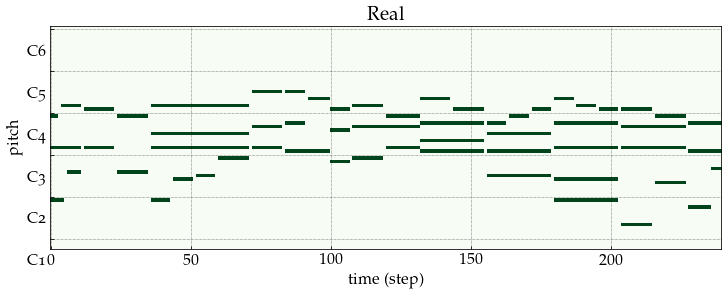

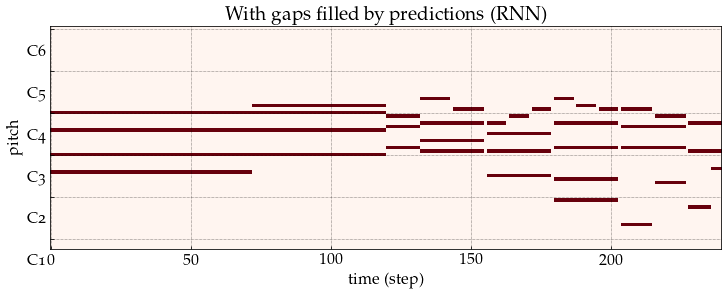

In [13]:
plt.rcParams["figure.figsize"] = (10, 4)
x1 = errors[0]
x2 = errors[0] + 240
pyplot_piano_roll(before[x1:x2], low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Greens')
plt.title("Real")
plt.ylim([33, 97])

pyplot_piano_roll(test_file[x1:x2], low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Reds')
plt.title("With gaps filled by predictions (RNN)")
plt.ylim([33, 97])
# plt.savefig(PLOTS / (FILE + '-rnn.png'))

[588, 876, 1164, 1452, 1740, 2028, 2316, 2604]
[588, 708, 876, 996, 1164, 1284, 1452, 1572, 1740, 1860, 2028, 2148, 2316, 2436, 2604, 2724]


(33.0, 97.0)

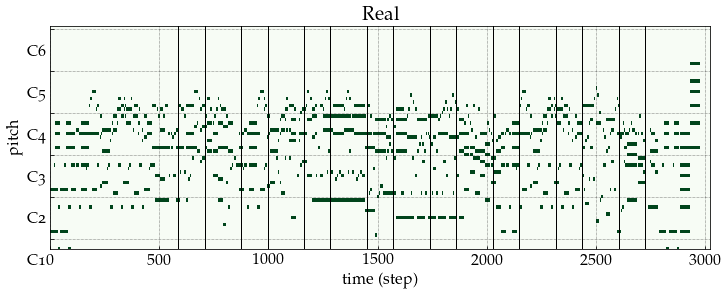

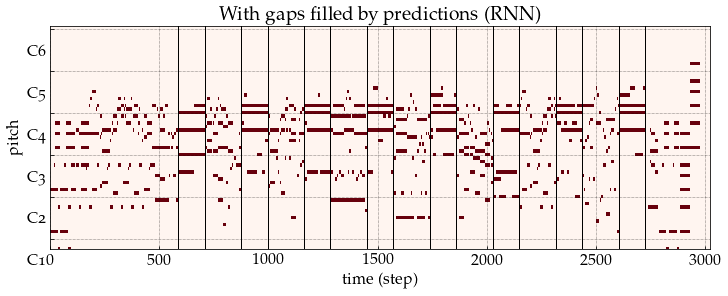

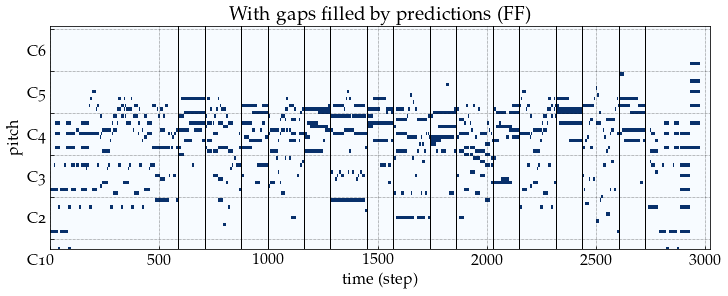

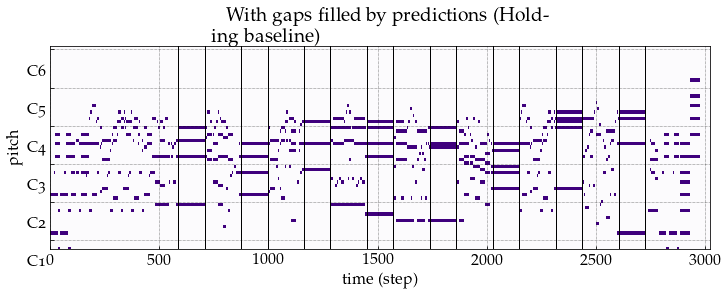

In [14]:
plt.rcParams["figure.figsize"] = (10, 4)
dbs=[y+x for y in errors for x in [0, 120]]
print(errors)
print(dbs)
pyplot_piano_roll(before, low_lim=+LOW_LIM, high_lim=HIGH_LIM, db=dbs, cmap='Greens')
plt.title("Real")
plt.ylim([33, 97])
# plt.savefig(PLOTS / (FILE + '-real.png'))

pyplot_piano_roll(test_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, db=dbs, cmap='Reds')
plt.title("With gaps filled by predictions (RNN)")
plt.ylim([33, 97])
# plt.savefig(PLOTS / (FILE + '-rnn.png'))

pyplot_piano_roll(ff_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, db=dbs, cmap='Blues')
plt.title("With gaps filled by predictions (FF)")
plt.ylim([33, 97])
# plt.savefig(PLOTS / (FILE + '-ff.png'))

pyplot_piano_roll(base_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, db=dbs, cmap='Purples')
plt.title("With gaps filled by predictions (Holding baseline)")
plt.ylim([33, 97])
# plt.savefig(PLOTS / (FILE + '-ff.png'))

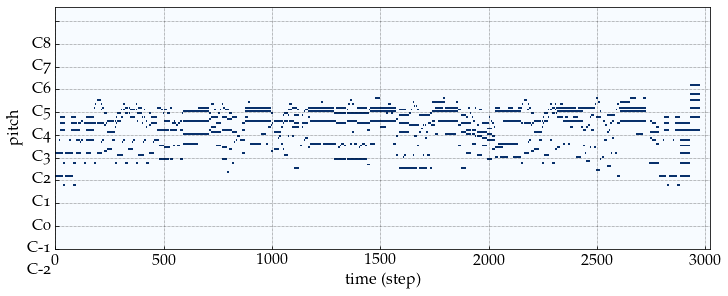

In [15]:
pyplot_piano_roll(test_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM)

# tempo = 80
tempo = 120

# f0 = copy.deepcopy(test_file)
# dataset.write_midi(f0, str(P / 'audio_output' / (FILE + '_filled_rnn.mid')),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

# f1 = copy.deepcopy(ff_file)
# dataset.write_midi(f1, str(P / 'audio_output' / (FILE + '_filled_ff.mid')),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

# f3 = copy.deepcopy(base_file)
# dataset.write_midi(f3, str(P / 'audio_output' / (FILE + '_filled_base.mid')),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

f0 = copy.deepcopy(test_file)
# dataset.write_midi(f0, (FILE + '_filled_rnn.mid'),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

f1 = copy.deepcopy(ff_file)
# dataset.write_midi(f1, (FILE + '_filled_ff.mid'),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

f3 = copy.deepcopy(base_file)
# dataset.write_midi(f3, (FILE + '_filled_base.mid'),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

In [16]:
# end = STOP + 120

# past = dataset.downsample_roll(test_file[STOP:end, :], 10, 12)
# past = np.array([past])

# predictions = model.predict(past)
# predictions_bin = dataset.ranked_threshold(predictions, steps=10, how_many=5)
# predictions_bin = predictions_bin.reshape((10, 64))
# # pyplot_piano_roll(predictions_bin, low_lim=+LOW_LIM, high_lim=HIGH_LIM)

# upsampled = copy.deepcopy(predictions_bin)
# upsampled = dataset.upsample_roll(upsampled, 10, 12)
# # pyplot_piano_roll(arr, low_lim=+LOW_LIM, high_lim=HIGH_LIM)

# final = copy.deepcopy(test_file)
# final[end: end+12*5] = upsampled[:12*5]
